In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt

In [2]:
# Create the CartPole environment
env = gym.make('CartPole-v1')

# Wrap the environment in a vectorized environment (required by Stable Baselines3)
# Using DummyVecEnv directly without Monitor
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True)

# Define the model: PPO (Proximal Policy Optimization)
model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    verbose=1
)

Using cpu device


In [6]:
# Set up evaluation callback
eval_env = gym.make('CartPole-v1')
eval_env = DummyVecEnv([lambda: eval_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, training=False)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model",
    log_path="./logs/",
    eval_freq=1000,
    deterministic=True,
    render=False
)

# Train the model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the model
model.save("ppo_cartpole")

# Load the model for testing
loaded_model = PPO.load("ppo_cartpole", env=vec_env)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(loaded_model, vec_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Function to visualize the trained agent
def visualize_policy(model, env, num_episodes=5):
    # Use render_mode='human' in the new Gymnasium API
    test_env = gym.make('CartPole-v1', render_mode='human')
    obs, _ = test_env.reset()  # New Gymnasium API returns (obs, info)
    
    for episode in range(num_episodes):
        done = False
        truncated = False
        total_reward = 0
        
        while not (done or truncated):
            # Normalize the observation as done during training
            norm_obs = vec_env.normalize_obs(np.array([obs]))
            action, _states = model.predict(norm_obs, deterministic=True)
            obs, reward, done, truncated, info = test_env.step(action[0])
            total_reward += reward
            
            if done or truncated:
                print(f"Episode {episode+1}: Total Reward: {total_reward}")
                obs, _ = test_env.reset()
                break
    
    test_env.close()

Eval num_timesteps=1000, episode_reward=5.56 +/- 1.91
Episode length: 50.60 +/- 17.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 50.6     |
|    mean_reward     | 5.56     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------


c:\Users\james\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=2000, episode_reward=3.94 +/- 2.53
Episode length: 35.60 +/- 22.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 35.6     |
|    mean_reward     | 3.94     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
-----------------------------
| time/              |      |
|    fps             | 1454 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Eval num_timesteps=3000, episode_reward=9.97 +/- 3.55
Episode length: 133.20 +/- 47.41
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 133         |
|    mean_reward          | 9.97        |
| time/                   |             |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.014901802 |
|    clip_fraction   

In [8]:
# visualize_policy(loaded_model, vec_env)

def plot_cart_pole_dynamics(model, env, num_episodes=5):
    # Use render_mode=None for data collection without rendering
    test_env = gym.make('CartPole-v1', render_mode=None)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_episodes, 1, figsize=(12, 3*num_episodes), sharex=True)
    if num_episodes == 1:
        axes = [axes]  # Ensure axes is a list for consistent indexing
    
    # Lists to collect all values (to determine global ranges if needed)
    all_positions = []
    all_angles = []
    
    # First, collect data from all episodes
    episode_data = []
    for episode in range(num_episodes):
        obs, _ = test_env.reset()
        positions = []
        angles = []
        timestamps = []
        done = False
        truncated = False
        total_reward = 0
        timestep = 0
        
        while not (done or truncated):
            norm_obs = vec_env.normalize_obs(np.array([obs]))
            action, _states = model.predict(norm_obs, deterministic=True)
            obs, reward, done, truncated, info = test_env.step(action[0])
            
            positions.append(obs[0])  # Cart position
            angles.append(obs[2])     # Pole angle
            timestamps.append(timestep)
            
            all_positions.append(obs[0])
            all_angles.append(obs[2])
            
            total_reward += reward
            timestep += 1
            
            if done or truncated:
                print(f"Episode {episode+1}: Total Reward: {total_reward}")
                break
        
        episode_data.append((timestamps, positions, angles, total_reward))
    
    # Now plot all episodes with consistent y-axes
    for episode, (timestamps, positions, angles, total_reward) in enumerate(episode_data):
        ax1 = axes[episode]
        
        # Plot position on the left y-axis
        color_pos = 'tab:blue'
        ax1.set_xlabel('Timestep')
        ax1.set_ylabel('Cart Position', color=color_pos)
        ax1.plot(timestamps, positions, color=color_pos, label='Cart Position')
        ax1.tick_params(axis='y', labelcolor=color_pos)
        # Set fixed y-axis limits for position
        ax1.set_ylim(-2.4, 2.4)
        
        # Create a second y-axis for angle
        ax2 = ax1.twinx()
        color_angle = 'tab:red'
        ax2.set_ylabel('Pole Angle', color=color_angle)
        ax2.plot(timestamps, angles, color=color_angle, label='Pole Angle')
        ax2.tick_params(axis='y', labelcolor=color_angle)
        # Set fixed y-axis limits for angle (using a consistent range)
        angle_max = max(abs(min(all_angles)), abs(max(all_angles)))
        ax2.set_ylim(-0.25, 0.25)  # Set reasonable range for pole angle
        
        # Add title with episode number and reward
        ax1.set_title(f'Episode {episode+1} - Reward: {total_reward}')
        
        # Add legend with both lines
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    test_env.close()


In [11]:
# After visualizing the agent
visualize_policy(loaded_model, vec_env)

Episode 1: Total Reward: 500.0
Episode 2: Total Reward: 500.0
Episode 3: Total Reward: 500.0
Episode 4: Total Reward: 500.0
Episode 5: Total Reward: 500.0


Episode 1: Total Reward: 500.0
Episode 2: Total Reward: 500.0
Episode 3: Total Reward: 500.0
Episode 4: Total Reward: 500.0
Episode 5: Total Reward: 500.0


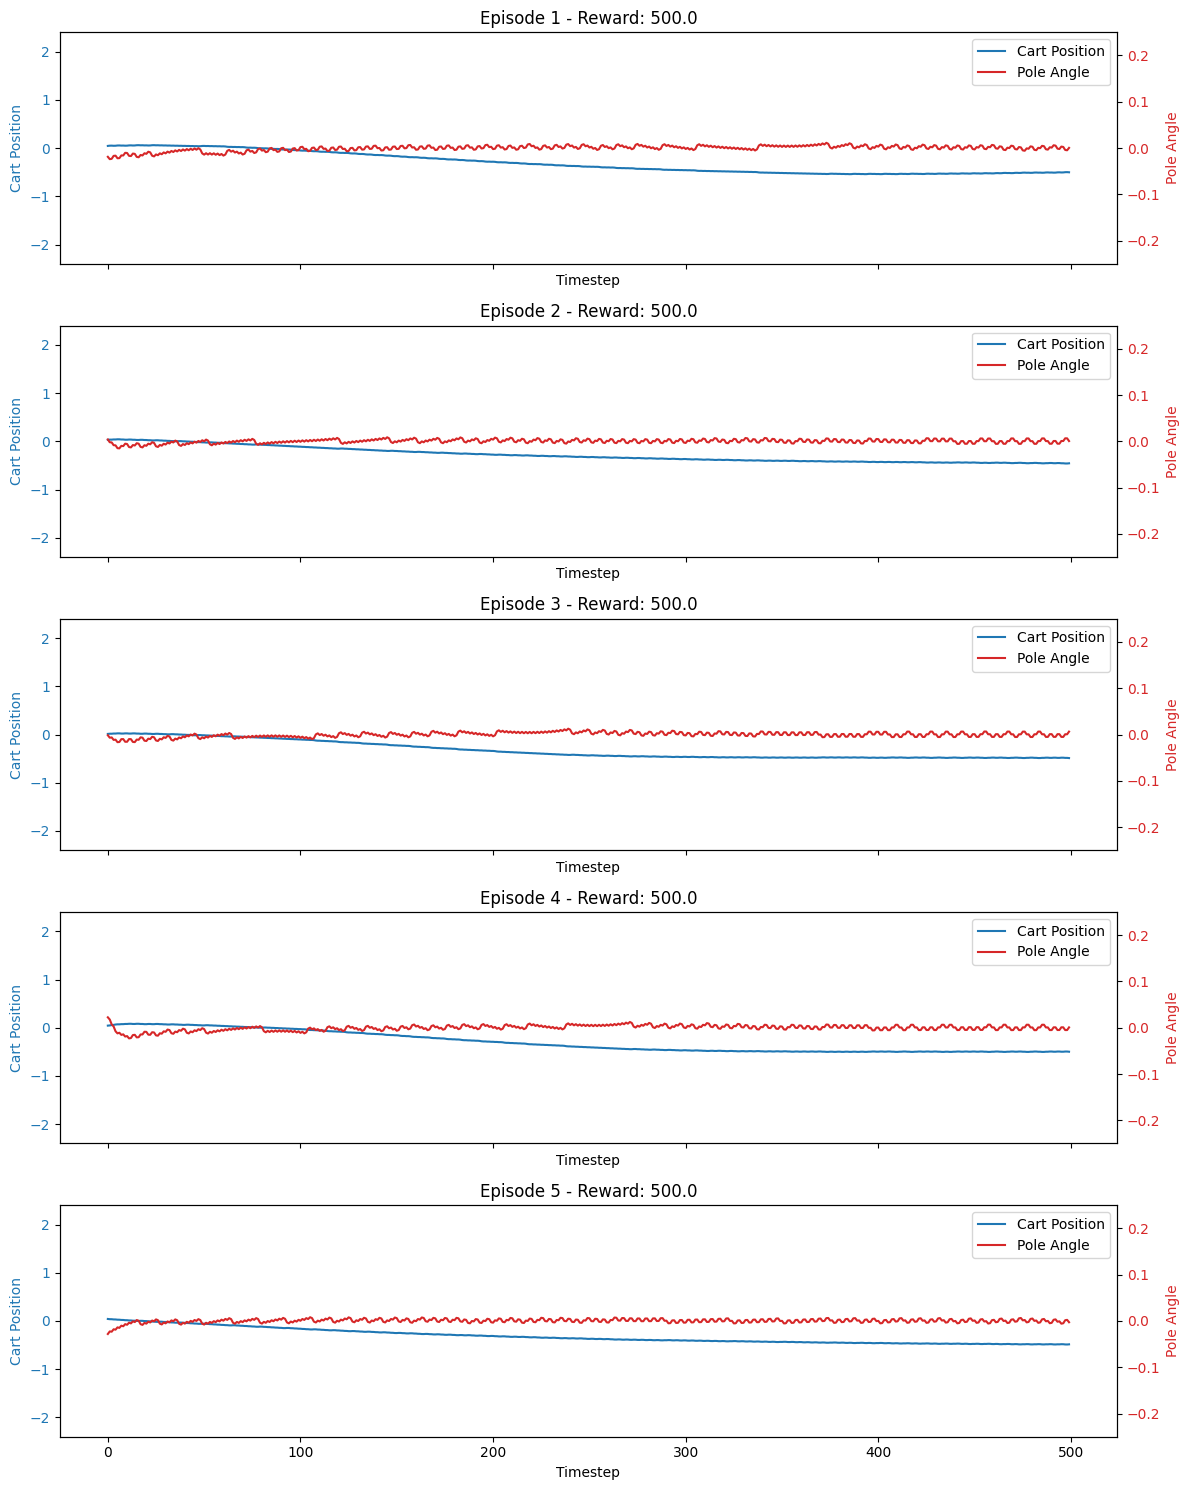

In [10]:
# Now call the plotting function to generate the graphs
plot_cart_pole_dynamics(loaded_model, vec_env, num_episodes=5)

In [ ]:
## Second method

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib import animation
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import os

class CustomCartPoleEnv(gym.Env):
    def __init__(self):
        super(CustomCartPoleEnv, self).__init__()
        
        # System parameters
        self.M = 0.5      # Cart mass
        self.m = 0.2      # Pendulum mass
        self.b = 0.1      # Friction coefficient
        self.I = 0.006    # Moment of inertia
        self.g = 9.81     # Gravity
        self.l = 0.3      # Pendulum length
        self.Ts = 1/10    # Sampling time
        
        # State space matrices from the parameters
        A_22 = (-(self.I + self.m * self.l**2) * self.b) / (self.I * (self.M + self.m) + self.M * self.m * self.l**2)
        A_23 = (self.m**2 * self.g * self.l**2) / (self.I * (self.M + self.m) + self.M * self.m * self.l**2)
        A_42 = (-self.m * self.l * self.b) / (self.I * (self.M + self.m) + self.M * self.m * self.l**2)
        A_43 = ((self.m * self.g * self.l) * (self.M + self.m)) / (self.I * (self.M + self.m) + self.M * self.m * self.l**2)
        B_2 = (self.I + self.m * self.l**2) / (self.I * (self.M + self.m) + self.M * self.m * self.l**2)
        B_4 = (self.m * self.l) / (self.I * (self.M + self.m) + self.M * self.m * self.l**2)
        
        self.A = np.array([
            [0, 1, 0, 0],
            [0, A_22, A_23, 0],
            [0, 0, 0, 1],
            [0, A_42, A_43, 0]
        ])
        
        self.B = np.array([[0], [B_2], [0], [B_4]])
        self.C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
        self.D = np.array([[0], [0]])
        
        # Define action and observation space
        # Action space: force applied to the cart
        self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(1,), dtype=np.float32)
        
        # Observation space: [x, x_dot, theta, theta_dot]
        # x: cart position, x_dot: cart velocity
        # theta: pole angle, theta_dot: pole angular velocity
        self.observation_space = spaces.Box(
            low=np.array([-5.0, -5.0, -np.pi, -5.0]),
            high=np.array([5.0, 5.0, np.pi, 5.0]),
            dtype=np.float32
        )
        
        # Initial state
        self.state = None
        self.max_steps = 500
        self.current_step = 0
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Initialize with small random values
        self.state = np.random.uniform(low=-0.05, high=0.05, size=4)
        self.current_step = 0
        
        # Return observation and info
        return self.state.astype(np.float32), {}
        
    def step(self, action):
        # Make sure action is a scalar
        u = np.clip(action[0], self.action_space.low[0], self.action_space.high[0])
        
        # Apply system dynamics using discrete approximation
        x_dot = np.dot(self.A, self.state.reshape(-1, 1)) + self.B * u
        self.state = self.state + (x_dot.flatten() * self.Ts)
        
        # Normalize angle to [-pi, pi]
        self.state[2] = ((self.state[2] + np.pi) % (2 * np.pi)) - np.pi
        
        # Calculate reward
        x, x_dot, theta, theta_dot = self.state
        
        # Higher reward for staying upright (theta near 0) and centered (x near 0)
        angle_penalty = abs(theta)
        position_penalty = abs(x)
        velocity_penalty = 0.1 * (abs(x_dot) + abs(theta_dot))
        
        reward = 1.0 - angle_penalty - 0.5 * position_penalty - velocity_penalty
        
        # Check if episode is done
        self.current_step += 1
        terminated = bool(
            x < -2.5
            or x > 2.5
            or theta < -0.7
            or theta > 0.7
            or self.current_step >= self.max_steps
        )
        
        truncated = False
        info = {}
        
        return self.state.astype(np.float32), reward, terminated, truncated, info

def train_cart_pole_rl():
    # Create the environment
    env = CustomCartPoleEnv()
    
    # Create the RL model (PPO)
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=0.0003,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        verbose=1
    )
    
    # Train the model
    model.learn(total_timesteps=100000)
    
    # Save the model
    model.save("ppo_cartpole")
    
    return model, env

def animate_cart_pole_gif(states, filename="cart_pole_animation.gif"):
    """
    Create a GIF animation of the cart pole system
    
    Args:
        states: numpy array of shape (timesteps, 4) with states [x, x_dot, theta, theta_dot]
        filename: name of the output file
    """
    # Cart and pole dimensions
    cart_width = 0.5
    cart_height = 0.25
    pole_length = 0.3  # matches the system parameter l
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(-3, 3)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title('Cart-Pole Animation')
    ax.set_xlabel('Position (m)')
    
    # Initialize cart and pole objects
    cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='blue', ec='black')
    pole = plt.Line2D([0, 0], [0, pole_length], lw=4, c='red')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    def init():
        # Initialize animation
        ax.add_patch(cart)
        ax.add_line(pole)
        time_text.set_text('')
        return cart, pole, time_text
    
    def animate(i):
        # Update animation
        x = states[i, 0]
        theta = states[i, 2]
        
        # Update cart position
        cart.set_xy([x - cart_width/2, 0])
        
        # Update pole position (origin at the center of the cart)
        pole_x = x + pole_length * np.sin(theta)
        pole_y = cart_height + pole_length * np.cos(theta)
        pole.set_xdata([x, pole_x])
        pole.set_ydata([cart_height, pole_y])
        
        time_text.set_text(f'Time: {i*0.1:.1f}s')
        
        return cart, pole, time_text
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=len(states), interval=100, blit=True
    )
    
    # Save animation as GIF using pillow
    # Sample frames at a lower rate to keep file size reasonable
    # Use every 3rd frame to create a good balance of smoothness and file size
    sample_rate = 3
    sampled_frames = range(0, len(states), sample_rate)
    
    anim = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=sampled_frames, interval=100*sample_rate, blit=True
    )
    
    # Save animation as GIF
    anim.save(filename, writer='pillow', fps=10, dpi=80)
    
    plt.close()
    
    return filename

def evaluate_and_visualize(model, env, num_episodes=3):
    # Evaluate the model
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
    
    # Visualize a few episodes
    for episode in range(num_episodes):
        obs, _ = env.reset()
        states = [obs]
        rewards = []
        actions = []
        
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            states.append(obs)
            rewards.append(reward)
            actions.append(action)
        
        states = np.array(states)
        actions = np.array(actions)
        
        # Create animation
        animation_file = f"cartpole_episode_{episode+1}.gif"
        animate_cart_pole_gif(states, animation_file)
        print(f"Created animation: {animation_file}")
        
        # Plot the episode results
        plt.figure(figsize=(15, 12))
        
        plt.subplot(5, 1, 1)
        plt.plot(states[:, 0])
        plt.title(f'Episode {episode+1}: Cart Position')
        plt.ylabel('Position (m)')
        plt.grid(True)
        
        plt.subplot(5, 1, 2)
        plt.plot(states[:, 1])
        plt.title('Cart Velocity')
        plt.ylabel('Velocity (m/s)')
        plt.grid(True)
        
        plt.subplot(5, 1, 3)
        plt.plot(states[:, 2])
        plt.title('Pole Angle')
        plt.ylabel('Angle (rad)')
        plt.grid(True)
        
        plt.subplot(5, 1, 4)
        plt.plot(states[:, 3])
        plt.title('Pole Angular Velocity')
        plt.ylabel('Angular Velocity (rad/s)')
        plt.grid(True)
        
        plt.subplot(5, 1, 5)
        plt.plot(actions)
        plt.title('Applied Force')
        plt.ylabel('Force (N)')
        plt.xlabel('Time Steps')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(f"cartpole_plots_episode_{episode+1}.png")
        plt.close()
        
        print(f"Episode {episode+1} completed with total reward: {sum(rewards):.2f}")

def main():
    # Train the model
    model, env = train_cart_pole_rl()
    
    # Evaluate and visualize
    evaluate_and_visualize(model, env)

if __name__ == "__main__":
    main()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.45     |
|    ep_rew_mean     | 4.06     |
| time/              |          |
|    fps             | 2401     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.04        |
|    ep_rew_mean          | 4.65        |
| time/                   |             |
|    fps                  | 1498        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007541091 |
|    clip_fraction        | 0.0811      |
|    clip_range           | 0.2         |
|    entropy_loss   